# Generating data for neglected bugs from the microbiome

The main point the figure should communicate is that there is a sharp disconnect from the the bugs that are engineered by scientists and the bugs that are highly represented in our actual gut microbiome, and shape our daily life and health.

The main data points are papers from pubmed, where the input data is a title and an abstract. We needed to generate the data from scratch, and we did this using an iterative approach towards a dataset to visualize.

For each paper, we identified two questions to ask:

1. Are the authors of the paper genetically modifing a microorganism?
2. Are the authors of the paperinvestigating the specific bacteria we are looking for?

We are then constructing one model to answer question 1 for all papers, and one model for each bacterial genus. Since question 1 will overlap on all the different bacteria, we can lump the data and create a stronger model.

# Iteration 1: Keyword Search

The first dataset was created by a simple keyword search in the Pubmed database. The keywords in question was:

> engineer OR crispr OR transformation OR vector OR recombinant

A web interface was constructed to quickly make query calls to Pubmed and display the abstracts, as well as to enter the relevant information, so not to waste time on clicking around in a webbrowser too much. The interface is located in the `resfinder` directory.

# Iteration 2: A model for finding engineering papers

Once about a 100 papers were collected and classified, a model was constructed to predict whether a paper was an engineering paper or not. A random forest model was chosen due to the fact that it usually performs well without much parameter tuning needed. The random forest model has the additional advantage of being able to estimate the error based on the out-of-bag score.

More effort could have been put into model selection and parameter tuning, but this was deemed out of scope for this assignment.

## Vectorizing abstracts and papers

`TfidfVectorizer` from `scikit-learn` was used to vectorize the input data into a format understood be the RF model:

In [1]:
%matplotlib inline

import json

import numpy as np
import scipy.sparse
import sklearn.ensemble
from sklearn.feature_extraction.text import TfidfVectorizer

# Code for fetching abstracts from pubmed
import reffinder.utils
import reffinder.ml


BUGS = [
    'Clostridium',
    'Ruminococcus',
    'Lactobacillus',
    'Lactococcus',
    'Streptococcus',
    'Staphylococcus',
    'Listeria',
    'Treponema',
    'Borrelia',
    'Bifidobacterium',
    'Actinomyces',
    'Mycobacterium',
    'Propionibacteria',
    'Porphyromonas',
    'Prevotella',
    'Bacteroides',
    'Fusobacterium',
    'Escherichia',
    'Helicobacter',
    'Campylobacter',
    'Rickettsia',
    'Brucella',
    'Bordetella',
    'Neisseria',
    'Pseudomonas',
]

# The collected data from a JSON file

with open('reffinder/data/data.json') as f:
    raw = json.load(f)

# We try to limit the influence each genus has on the final prediction, 
# so we add the bugname to the stop words:

stop_words = sklearn.feature_extraction.stop_words.ENGLISH_STOP_WORDS | set(b.lower() for b in BUGS)

# We make a separate vectorizer for the title and the abstract, 
# as the significance of a word in one may be different from the other

X_txt_titles    = []
X_txt_abstracts = []
y_engineering   = []

cached = reffinder.ml.load_abstract_cache()

for bug, papers in raw.items():
    for pmid, res in papers.items():
        paper = reffinder.utils.retrieve_abstracts([pmid], cached)[pmid]
        X_txt_titles.append(paper['title'])
        X_txt_abstracts.append(paper['abstract'])
        y_engineering.append(int(res['is_eng']))

max_title_words = 200

# And here we define the actual vectorizers
        
titles_vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    stop_words=stop_words,
    ngram_range=(1, 3),
    max_features=max_title_words,
)

abstracts_vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    stop_words=stop_words,
    ngram_range=(1, 2),
    max_features=1000,
)

# Which we then fit to the data 
# and transform it into vectors

X_titles = titles_vectorizer.fit_transform(X_txt_titles)
X_abstracts = abstracts_vectorizer.fit_transform(X_txt_abstracts)

# Concatenate the titles and abstract vectors

X = scipy.sparse.hstack((X_titles, X_abstracts))
y = np.array(y_engineering)

print('Input:', X.shape)
print('Labels:', y.shape)

Input: (1511, 1200)
Labels: (1511,)


## Constructing the Random Forest

Scikit-learn makes constructing a random forest model easy:

In [2]:
eng_estimator = sklearn.ensemble.RandomForestClassifier(
    n_estimators=200,
    n_jobs=12,
    oob_score=True,
    random_state=13
)

eng_estimator.fit(X, y)

print('OOB accuracy estimation: {:.1%}'.format(eng_estimator.oob_score_))

OOB accuracy estimation: 83.4%


## Looking at the model: ROC curve

An interesting look into the model is via the ROC (receiver operating characteristic) curve, where the true positive rate (sensitivity) is plotted against the false positive rate for each prediction in the dataset.

Again, Scikit-learn makes this really easy:

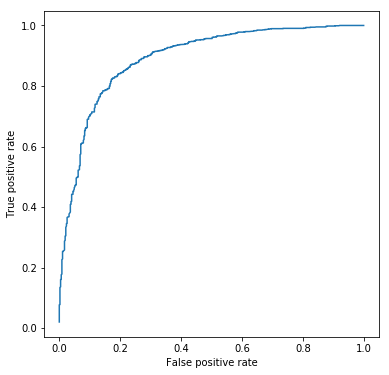

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import sklearn.metrics

fpr, tpr, thr = sklearn.metrics.roc_curve(y, eng_estimator.oob_decision_function_[:, 1])

fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

ax.plot(fpr, tpr)
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
pass

We can the calculate the specificity and sensitivity for the "default" threshold (0.5). We can optimize the threshold using a simple simple method where TPR - FPR is maximized:

Default sensitivity: 93.8%
Default specificity: 58.8%

New threshold: 0.699
New sensitivity: 82.6%
New specificity: 82.5%
New accuracy: 82.5%


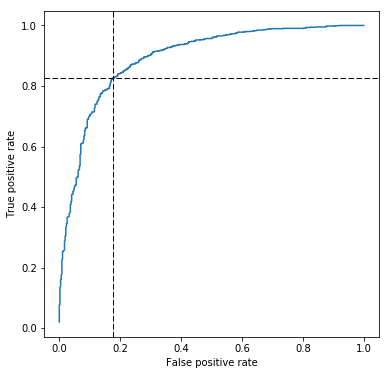

In [4]:
threshold = 0.5
idx = np.argmin(np.abs(thr - threshold))
sensitivity = tpr[idx]
specificity = 1 - fpr[idx]

print('Default sensitivity: {:.1%}'.format(sensitivity))
print('Default specificity: {:.1%}'.format(specificity))

new_idx = np.argmax(tpr - fpr)
new_sensitivity = tpr[new_idx]
new_specificity = 1 - fpr[new_idx]
engineering_threshold = thr[new_idx]

print()
print('New threshold: {:.3f}'.format(engineering_threshold))
print('New sensitivity: {:.1%}'.format(new_sensitivity))
print('New specificity: {:.1%}'.format(new_specificity))

fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

ax.plot(fpr, tpr)
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')

ax.axhline(tpr[new_idx], color='k', linestyle='--', lw=1)
ax.axvline(fpr[new_idx], color='k', linestyle='--', lw=1)

# Calculate the new accuracy as well

pred_labels = eng_estimator.oob_decision_function_[:, 1] > engineering_threshold
new_accuracy = np.average(pred_labels == y_engineering)

print('New accuracy: {:.1%}'.format(new_accuracy))

### Feature importances

Another great feature of the random forest is that it gives us an estimation on the importance of each feature. This importance estimate is calculated based on how often a particular feature is used to create a split in a decision tree.

We can translate these importances back into words to list the keywords that are important:

In [5]:
scaled_importance = eng_estimator.feature_importances_ / np.max(eng_estimator.feature_importances_)

importances = {
    'title': {w: scaled_importance[i] for w, i in titles_vectorizer.vocabulary_.items()},
    'abstract': {w: scaled_importance[i + max_title_words] for w, i in abstracts_vectorizer.vocabulary_.items()},
}

n_words = 25

print('In the title:')
for w, i in sorted(importances['title'].items(), key=lambda e: e[1], reverse=True)[:n_words]:
    print('{:<20} {:.3f}'.format(w, i))
    
print()
print('In the abstract:')
for w, i in sorted(importances['abstract'].items(), key=lambda e: e[1], reverse=True)[:n_words]:
    print('{:<20} {:.3f}'.format(w, i))

In the title:
cloning              0.346
expression           0.271
coli                 0.179
recombinant          0.157
engineering          0.121
gene                 0.091
expressing           0.075
lactis               0.062
production           0.058
monocytogenes        0.058
construction         0.057
microbiota           0.055
crispr               0.054
protein              0.053
sequence             0.053
genome               0.044
characterization     0.040
human                0.038
plasmid              0.037
dna                  0.033
genome sequence      0.032
cas9                 0.032
bacteria             0.032
infection            0.032
aeruginosa           0.029

In the abstract:
coli                 1.000
recombinant          0.844
gene                 0.623
plasmid              0.519
vector               0.450
constructed          0.431
engineering          0.346
expressed            0.246
expression           0.229
engineered           0.213
cloned               0.

## Iteration 3: Genus-specific models

Using the model makes it easier to find new papers with the correct classification. Simply download all hits for each organism and sort the papers by predictions.

We then construct models to predict whether a paper is about a bug or not. An alternative strategy would create a single model with multiple output classes.

The code is vary similar to the one above. The same vectorizers are used.

In [6]:
# We create an estimator for each bug and put it into this dictionary
bug_estimators = {}
y_data = {}

for query_bug in BUGS:
    txt_titles    = []
    txt_abstracts = []
    y             = []

    for bug, papers in raw.items():
        for pmid, res in papers.items():
            paper = reffinder.utils.retrieve_abstracts([pmid], cached=cached)[pmid]
            txt_titles.append(paper['title'])
            txt_abstracts.append(paper['abstract'])
            #
            y.append(int(res['is_bug'] and bug == query_bug))
            
    X_titles = titles_vectorizer.transform(txt_titles)
    X_abstracts = abstracts_vectorizer.transform(txt_abstracts)
    X = scipy.sparse.hstack((X_titles, X_abstracts))
    
    print('{:<20} Positives: {:>3} / {}'.format(query_bug, np.sum(y), len(y)))
    
    bug_estimator = sklearn.ensemble.RandomForestClassifier(
        n_estimators=100,
        n_jobs=12,
        oob_score=True,
        random_state=13
    )

    bug_estimators[query_bug] = bug_estimator.fit(X, y)
    y_data[query_bug] = y

Clostridium          Positives:  67 / 1511
Ruminococcus         Positives:  18 / 1511
Lactobacillus        Positives: 103 / 1511
Lactococcus          Positives:  43 / 1511
Streptococcus        Positives:  23 / 1511
Staphylococcus       Positives:  22 / 1511
Listeria             Positives:  32 / 1511
Treponema            Positives:  44 / 1511
Borrelia             Positives:  31 / 1511
Bifidobacterium      Positives:  32 / 1511
Actinomyces          Positives:  19 / 1511
Mycobacterium        Positives:  35 / 1511
Propionibacteria     Positives:  40 / 1511
Porphyromonas        Positives:  16 / 1511
Prevotella           Positives:  12 / 1511
Bacteroides          Positives:  18 / 1511
Fusobacterium        Positives:   9 / 1511
Escherichia          Positives: 247 / 1511
Helicobacter         Positives:  13 / 1511
Campylobacter        Positives:  16 / 1511
Rickettsia           Positives:  10 / 1511
Brucella             Positives:   7 / 1511
Bordetella           Positives:   5 / 1511
Neisseria  

### Roc curves again

Similarly to above, we calculate the ROC curves and the optimal threshold.

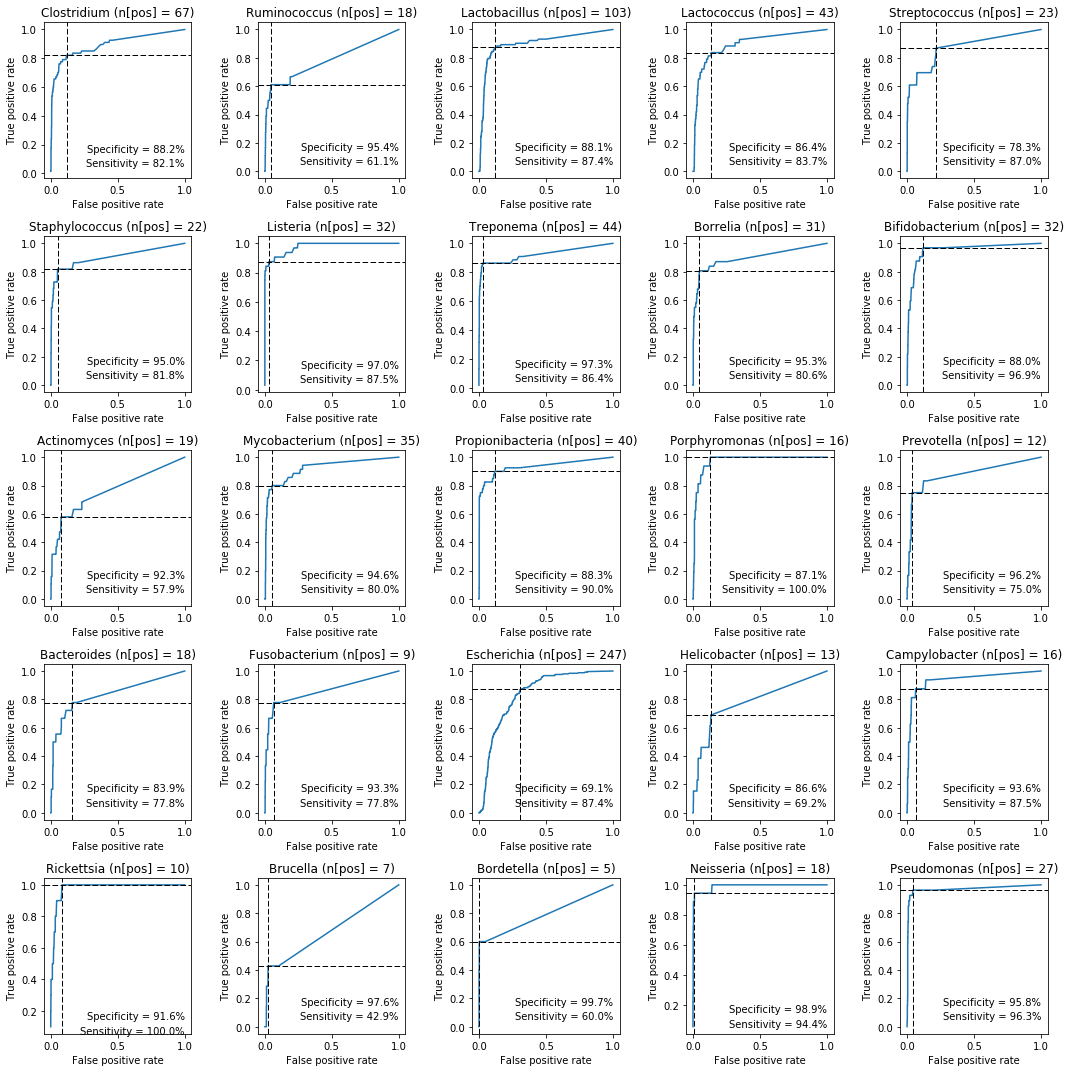

In [7]:
thresholds = {}

fig, axes = plt.subplots(5, 5)
fig.set_size_inches(15, 15)

axes = [ax for row in axes for ax in row]

for i, bug in enumerate(BUGS):
    ax = axes[i]
    bug_estimator = bug_estimators[bug]
    
    #print(estimator.oob_decision_function_.shape)
    fpr, tpr, thr = sklearn.metrics.roc_curve(y_data[bug], bug_estimator.oob_decision_function_[:, 1])
    ax.plot(fpr, tpr)
    
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('{} (n[pos] = {})'.format(bug, np.sum(y_data[bug])))
    
    idx = np.argmax(tpr - fpr)
    sensitivity = tpr[idx]
    specificity = 1 - fpr[idx]
    bug_threshold = thr[idx]
    
    thresholds[bug] = bug_threshold
    
    ax.axhline(tpr[idx], color='k', linestyle='--', lw=1)
    ax.axvline(fpr[idx], color='k', linestyle='--', lw=1)
    
    ax.text(1, 0.05, 'Sensitivity = {:.1%}'.format(sensitivity), ha='right')
    ax.text(1, 0.15, 'Specificity = {:.1%}'.format(specificity), ha='right')
    
fig.tight_layout()

# Putting it all together

Finally, we download all papers related to each bacteria and predict all of them to be hits or no hits.

In [8]:
predicted_papers = {}

for bug in BUGS:
    # Get all papers searching for a bug
    all_pmids = reffinder.utils.get_abstracts(bug, None, [])
    abstracts = reffinder.utils.retrieve_abstracts(all_pmids)
    
    X_txt_titles    = []
    X_txt_abstracts = []
    pmids = []

    for pmid, paper in abstracts.items():
        if paper is not None:
            X_txt_titles.append(paper['title'])
            X_txt_abstracts.append(paper['abstract'])
            pmids.append(pmid)
            
    X_titles = titles_vectorizer.transform(X_txt_titles)
    X_abstracts = abstracts_vectorizer.transform(X_txt_abstracts)
    X = scipy.sparse.hstack((X_titles, X_abstracts))
    
    bug_estimator = bug_estimators[bug]
    bug_y = bug_estimator.predict_proba(X)[:, 1].flatten()
    
    eng_y = eng_estimator.predict_proba(X)[:, 1].flatten()
    
    eng_positive = eng_y > engineering_threshold
    bug_positive = bug_y > thresholds[bug]
    
    positives = np.logical_and(eng_positive, bug_positive)
    positive_pmids = np.array(pmids)[positives]
    
    predicted_papers[bug] = positive_pmids
    
    print('{:<20} {:>6,} / {:>7,}'.format(bug, len(positive_pmids), len(pmids)))

Clostridium             464 /  30,524
Ruminococcus              9 /     930
Lactobacillus           664 /  24,437
Lactococcus             978 /   6,066
Streptococcus           562 /  74,857
Staphylococcus          509 / 107,804
Listeria                 90 /  16,958
Treponema                97 /   5,787
Borrelia                139 /   9,496
Bifidobacterium         105 /   6,483
Actinomyces              29 /   4,473
Mycobacterium         1,051 /  71,788
Propionibacteria         11 /     411
Porphyromonas            66 /   7,333
Prevotella               12 /   4,293
Bacteroides             124 /  12,546
Fusobacterium            13 /   4,660
Escherichia          62,860 / 292,612
Helicobacter            242 /  35,003
Campylobacter           238 /  13,158
Rickettsia               34 /   5,330
Brucella                 45 /   7,884
Bordetella               55 /  12,407
Neisseria               154 /  19,048
Pseudomonas           1,143 /  83,824


The code below just retrives the date of publication and outputs the final TSV file for the frontend figure.

In [9]:
phylums = {
    'Clostridium':      'Firmicutes',
    'Ruminococcus':     'Firmicutes',
    'Lactobacillus':    'Firmicutes',
    'Lactococcus':      'Firmicutes',
    'Streptococcus':    'Firmicutes',
    'Staphylococcus':   'Firmicutes',
    'Listeria':         'Firmicutes',
    'Treponema':        'Spirochaetes',
    'Borrelia':         'Spirochaetes',
    'Bifidobacterium':  'Actinobacteria',
    'Actinomyces':      'Actinobacteria',
    'Mycobacterium':    'Actinobacteria',
    'Propionibacteria': 'Actinobacteria',
    'Porphyromonas':    'Bacteroidetes',
    'Prevotella':       'Bacteroidetes',
    'Bacteroides':      'Bacteroidetes',
    'Fusobacterium':    'Fusobacteria',
    'Escherichia':      'Proteobacteria',
    'Helicobacter':     'Proteobacteria',
    'Campylobacter':    'Proteobacteria',
    'Rickettsia':       'Proteobacteria',
    'Brucella':         'Proteobacteria',
    'Bordetella':       'Proteobacteria',
    'Neisseria':        'Proteobacteria',
    'Pseudomonas':      'Proteobacteria',
}

import requests
import json
import bs4

months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', )


def get_pmid_details(pmids):
    try:
        with open('date_cache.json') as f:
            cached = json.load(f)
    except Exception:
        cached = {}
        
    db = 'pubmed'
    base = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
    
    new_pmids = [pmid for pmid in pmids if pmid not in cached]
    
    res = {pmid: cached[pmid] for pmid in pmids if pmid in cached}
    if not new_pmids:
        return res

    url = base + 'epost.fcgi?db={}'.format(db)
    req = requests.post(url, data={'id': ','.join(new_pmids)})
    soup = bs4.BeautifulSoup(req.text, 'lxml-xml')

    key = soup.find('QueryKey').text
    web = soup.find('WebEnv').text
    
    for i in range(0, len(new_pmids), 10000):
        params = {
            'db': db, 'query_key': key, 'WebEnv': web, 'rettype': 'xml',
            'retmode': 'xml', 'retstart': i,
        }
        url = base + 'efetch.fcgi'
        req = requests.get(url, params=params)
        soup = bs4.BeautifulSoup(req.text, 'lxml-xml')

        for art in soup.find_all('PubmedArticle'):
            #print(art)
            pmid = art.find('PMID').text
            pubdate = art.find('Journal').find('PubDate')
            if not pubdate.find('Year'):
                medlinedate = pubdate.find('MedlineDate')
                if not medlinedate:
                    print(art)
                    raise Exception
                spl = medlinedate.text.split()
                year = spl[0]
                if len(spl) > 1:
                    mon = spl[1][:3]
            else:
                year = pubdate.find('Year').text
                mon_txt = pubdate.find('Month')
                mon = '01'
                if mon_txt:
                    mon = mon_txt.text
                    
            month = 1   
            if mon:
                if mon in months:
                    month = months.index(mon) + 1
                else:
                    try:
                        month = int(mon)
                    except ValueError:
                        pass
            date = '{}-{:0>2}'.format(year, month)
            res[pmid] = date
            cached[pmid] = date
        
        with open('date_cache.json', 'w') as f:
            json.dump(cached, f)
            
    assert len(res) == len(pmids)
    return res


with open('predicted_articles.tsv', 'w') as f:
    print('phylum\tgenus\tperc\tdate\tpmid', file=f)

    for bug in BUGS:
        dates = get_pmid_details(predicted_papers[bug])
        for pmid in predicted_papers[bug]:
            print(phylums[bug], bug, 'NA', dates[pmid], pmid, file=f)
        print(bug)

Clostridium
Ruminococcus
Lactobacillus
Lactococcus
Streptococcus
Staphylococcus
Listeria
Treponema
Borrelia
Bifidobacterium
Actinomyces
Mycobacterium
Propionibacteria
Porphyromonas
Prevotella
Bacteroides
Fusobacterium
Escherichia
Helicobacter
Campylobacter
Rickettsia
Brucella
Bordetella
Neisseria
Pseudomonas
